In [1]:
import numpy as np 
import pandas as pd 
import json
import re
import matplotlib.pyplot as plt
import os
import torch
from torch import nn 
import pathlib

In [2]:
# Version 4 - Lowered learning rate and added weight decay to try and fix exploding gradients

In [3]:
base_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
folder = 'train'
record_id = '10016536018877742'

band_11 = np.load(os.path.join(base_dir,folder,record_id,'band_11.npy'))
band_14 = np.load(os.path.join(base_dir,folder,record_id,'band_14.npy')) 
band_15 = np.load(os.path.join(base_dir,folder,record_id,'band_15.npy'))
pix = np.load(os.path.join(base_dir,folder,record_id,'human_pixel_masks.npy'))
ind = np.load(os.path.join(base_dir,folder,record_id,'human_individual_masks.npy'))

In [4]:
data = open('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json')
meta = json.load(data)
meta = pd.DataFrame(meta)
data.close

<function TextIOWrapper.close()>

In [5]:
meta.head()

,record_id,projection_wkt,row_min,row_size,col_min,col_size,timestamp
0,3283699311323360356,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",1686563.50,-1960.975830,371650.9375,1947.130737,1.571009e+09
1,8563667897034605935,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",3182392.75,-1977.611084,360291.8125,1938.791138,1.566377e+09
2,6375533009500587038,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2702499.50,-2035.440063,830456.9375,1890.603882,1.570222e+09
3,3029407526724839139,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",2689881.50,-1998.106812,565498.7500,1918.643677,1.570406e+09
4,4486503791474809647,"PROJCS[""unknown"",GEOGCS[""unknown"",DATUM[""WGS_1...",4179394.25,-2073.804688,736862.0000,1853.664795,1.572367e+09


In [6]:
_T11_BOUNDS = (243,303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4,5)
_TDIFF_BOUNDS = (-4,2)

def normalize_range(data,bounds):
    return (data-bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band_15 - band_14,_TDIFF_BOUNDS)
g = normalize_range(band_14 - band_11,_CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band_14,_T11_BOUNDS)

false_color = np.clip(np.stack([r,g,b],axis=2),0,1)

N_TIMES_BEFORE = 4
img = false_color[...,N_TIMES_BEFORE]

Text(0.5, 1.0, 'Contrail mask on false color image')

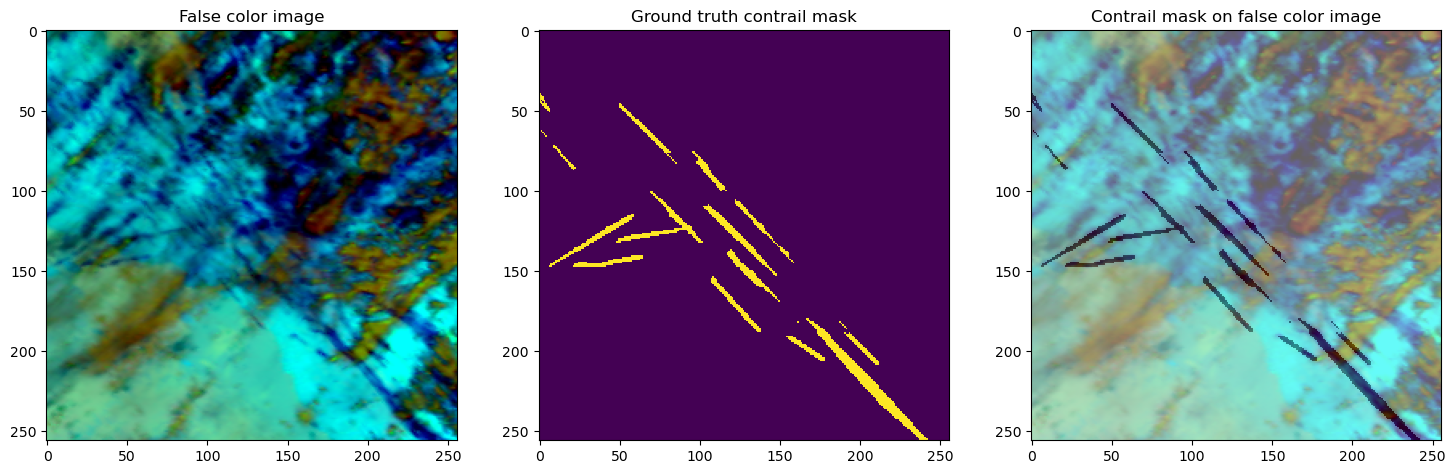

In [7]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1,3,2)
ax.imshow(pix,interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1,3,3)
ax.imshow(img)
ax.imshow(pix,cmap='Reds',alpha=.4,interpolation = 'none')
ax.set_title('Contrail mask on false color image')


In [8]:
target_dir = '/kaggle/input/contrails-data/Train'
valid_dir = '/kaggle/input/contrails-data/Valid'
len(list(pathlib.Path(target_dir).glob('*')))

20529

In [9]:
from torch.utils.data import Dataset
import pathlib
import numpy as np
import torch

class contrails(Dataset):
    def __init__(self,target_dir,transform = None, train = True):
        self.paths = list(pathlib.Path(target_dir).glob('*'))
        self.train = train
        
    def __getitem__(self,index):
        path = self.paths[index]
        record = np.load(path)
        
        img = record[..., :-1]
        label = record[..., -1]
        
        img = torch.tensor(img).permute(2,0,1).float()
        label = torch.tensor(label).unsqueeze(dim=0).float()
        
        return img, label
        
    def __len__(self):
        return len(self.paths)

In [10]:

train = contrails(target_dir)
valid = contrails(valid_dir)
print(train.__len__())
print(valid.__len__())

20529
1856


In [11]:
test = np.load('/kaggle/input/contrails-data/Train/1000216489776414077.npy')

In [12]:
test[...,:-1].shape

(256, 256, 3)

In [13]:
torch.tensor(test[...,-1]).unsqueeze(dim=0).shape

torch.Size([1, 256, 256])

In [14]:
img, label = train[0]
print(img.shape, label.shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


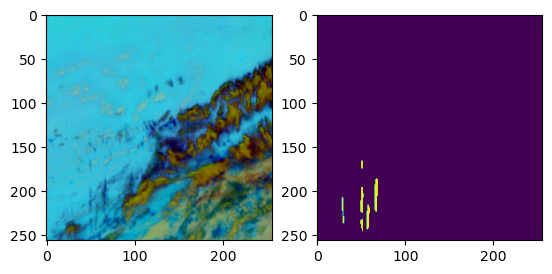

In [15]:
fig , (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.imshow(img.permute(1,2,0).numpy())
ax2.imshow(label.permute(1,2,0).numpy())

In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train,batch_size = 32,shuffle = True,num_workers=2)
valid_dataloader = DataLoader(valid, batch_size = 32,num_workers=2)

In [17]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 3, 256, 256])

In [18]:
from torch import nn 

class UNET(nn.Module):
    def __init__(self,input_units,hidden_units,output_shape,padding = 1):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(nn.Conv2d(input_units,hidden_units,kernel_size=3,padding=padding),
                                   nn.ReLU(),
                                   nn.Conv2d(hidden_units,hidden_units,kernel_size = 3,padding=padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2,stride=2),
                                   nn.Dropout(.25))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(hidden_units,hidden_units * 2,kernel_size = 3,padding = padding),
                                   nn.ReLU(),
                                   nn.Conv2d(hidden_units * 2,hidden_units * 2,kernel_size = 3,padding= padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2,stride = 2),
                                   nn.Dropout(.25))
        
        self.conv_block3 = nn.Sequential(nn.Conv2d(hidden_units * 2,hidden_units * 4,kernel_size = 3,padding = padding),
                                   nn.ReLU(),
                                   nn.Conv2d(hidden_units * 4,hidden_units * 4,kernel_size = 3,padding=padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = 2,stride = 2),
                                   nn.Dropout(.25))
        
        self.conv_block4 = nn.Sequential(nn.Conv2d(hidden_units * 4,hidden_units * 8,kernel_size = 3,padding=padding),
                                    nn.ReLU(),
                                    nn.Conv2d(hidden_units * 8,hidden_units * 8,kernel_size = 3,padding=padding),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2,stride = 2),
                                    nn.Dropout(.25),)
        
        self.middle_block = nn.Sequential(nn.Conv2d(hidden_units * 8,hidden_units * 16,kernel_size = 3,padding=padding),
                                    nn.Conv2d(hidden_units * 16,hidden_units * 16,kernel_size = 3,padding=padding))
        
        self.upconv_block1 = nn.Sequential(nn.ConvTranspose2d(hidden_units * 16,hidden_units * 8,kernel_size = 2,stride = 2),
                                     nn.Conv2d(hidden_units * 8,hidden_units * 8,kernel_size = 3,padding=padding),
                                     nn.Conv2d(hidden_units * 8,hidden_units * 8,kernel_size = 3,padding=padding),
                                        )
        
        self.upconv_block2 = nn.Sequential(nn.ConvTranspose2d(hidden_units * 8,hidden_units * 4,kernel_size = 2, stride = 2),
                                         nn.Conv2d(hidden_units * 4,hidden_units * 4,kernel_size = 3, padding = padding),
                                         nn.Conv2d(hidden_units * 4,hidden_units * 4,kernel_size = 3,padding = padding))
        
        self.upconv_block3 = nn.Sequential(nn.ConvTranspose2d(hidden_units * 4,hidden_units * 2,kernel_size = 2, stride = 2),
                                         nn.Conv2d(hidden_units * 2,hidden_units * 2,kernel_size = 3,padding = padding),
                                         nn.Conv2d(hidden_units * 2,hidden_units * 2,kernel_size = 3, padding = padding),
                                         )
        
        self.upconv_block4 = nn.Sequential(nn.ConvTranspose2d(hidden_units * 2,hidden_units,kernel_size = 2,stride = 2),
                                         nn.Conv2d(hidden_units ,hidden_units, kernel_size = 3 , padding = padding),
                                         nn.Conv2d(hidden_units,hidden_units,kernel_size =3 , padding = padding))
        
        self.outconv = nn.Conv2d(hidden_units,output_shape,kernel_size = 1)
    
        
        
    def forward(self,x):
        down = self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x))))
        middle = self.middle_block(down)
        up = self.outconv(self.upconv_block4(self.upconv_block3(self.upconv_block2(self.upconv_block1(middle)))))
        return up

In [19]:
model_0 = UNET(3,64,1)

In [20]:
model_0.parameters

<bound method Module.parameters of UNET(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [21]:
img, label = next(iter(train_dataloader))
prediction = model_0(img)
prediction.shape

torch.Size([32, 1, 256, 256])

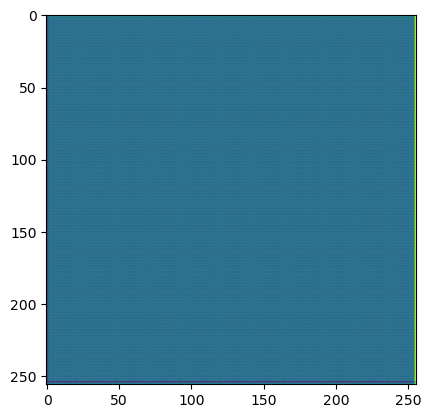

In [22]:
plt.imshow(prediction[0].permute(1,2,0).detach().numpy())

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(),lr = .0001, weight_decay = .0001)


In [25]:
model_0.to(device)
EPOCHS = 5

for epoch in range(EPOCHS):
    model_0.train()
    
    train_loss = 0 
    
    for batch, (X,y) in enumerate(train_dataloader):
        X , y = X.to(device) , y.to(device)
        
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred,y.float())
        train_loss += loss.item()
        
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
    train_loss /= len(train_dataloader)
    
    test_loss_total = 0 
    for batch , (X_test,y_test) in enumerate(valid_dataloader):
        
        model_0.eval()
        with torch.inference_mode():
            X_test , y_test = X_test.to(device), y_test.to(device)

            y_test_pred = model_0(X_test)

            test_loss = loss_fn(y_test_pred,y_test.float())

            test_loss_total += test_loss.item()
        
    test_loss_total /= len(valid_dataloader)
    
    print(f'Train Loss : {train_loss} Test Loss : {test_loss_total}')
        
        
    
    


Train Loss : 0.05254843802194219 Test Loss : 0.016134505802444344
Train Loss : 0.03356594538948618 Test Loss : 0.014676337957317973
Train Loss : 0.03300760291238254 Test Loss : 0.01764518806132777
Train Loss : 0.032827737831113125 Test Loss : 0.013323003723253977
Train Loss : 0.03264871769877748 Test Loss : 0.014526079553340015


In [26]:
train_loss

0.03264871769877748

In [27]:
PATH = pathlib.Path('Model_state_dict')

In [28]:
torch.save(model_0.state_dict(),PATH)